In [18]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [41]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education_df = pd.read_sql_query('SELECT * FROM useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Determine all the variable types and find the fraction of the missing values for each variable.
2. Notice that the data has a time dimension (year). For this assignment, forget about time and treat all the observations as if they're from the same year. Choose a strategy to deal with the missing values for each variables. For which variables would filling in the missing values with some value make sense? For which might tossing out the records entirely make sense?
3. Now, take into account the time factor. Replicate your second answer but this time fill in the missing values by using a statistic that is calculated within the year of the observation. For example, if you want to fill a missing value for a variable with the mean of that variable, calculate the mean by using *only* the observations for that specific year.
4. This time, fill in the missing values using interpolation (extrapolation).
5. Compare your results for the 2nd, 3rd, and 4th questions. Do you find any meaningful differences?

### 1. Variable Types and Fraction of Missing Values for Each Variable

1. Determine all the variable types and find the fraction of the missing values for each variable.

In [42]:
education_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [43]:
education_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

In [44]:
education_df.isnull().sum()/education_df.isnull().count()

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          0.176273
TOTAL_REVENUE                   0.142091
FEDERAL_REVENUE                 0.142091
STATE_REVENUE                   0.142091
LOCAL_REVENUE                   0.142091
TOTAL_EXPENDITURE               0.142091
INSTRUCTION_EXPENDITURE         0.142091
SUPPORT_SERVICES_EXPENDITURE    0.142091
OTHER_EXPENDITURE               0.176273
CAPITAL_OUTLAY_EXPENDITURE      0.142091
GRADES_PK_G                     0.115952
GRADES_KG_G                     0.088472
GRADES_4_G                      0.087802
GRADES_8_G                      0.087802
GRADES_12_G                     0.087802
GRADES_1_8_G                    0.087802
GRADES_9_12_G                   0.087802
GRADES_ALL_G                    0.115952
AVG_MATH_4_SCORE                0.640751
AVG_MATH_8_SCORE                0.643432
AVG_READING_4_SCORE             0.642761
AVG_READING_8_SC

### 2. Missing Values / Tossing Out Records
2. Notice that the data has a time dimension (year). For this assignment, forget about time and treat all the observations as if they're from the same year. Choose a strategy to deal with the missing values for each variables. For which variables would filling in the missing values with some value make sense? For which might tossing out the records entirely make sense?

We can fill in missing values with an imputation method with either the mean, median, mode, or even nan values. We might do this for the revenue variables or expenditure values (with a central tendency measure) as a zero value in these columns would skew our data greatly. Removing those rows would be risky as we don't know how much information that would remove. Scores for each grade level could also be filled in with values. Enroll is also another variable we can fill, perhaps with the mean.

In [45]:
education_df_copy1 = education_df

fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE", 
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE", 
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G", 
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G", 
             "GRADES_9_12_G", "GRADES_ALL_G"]

# impute columns with their mean
for col in fill_list:
    education_df_copy1.loc[:, col] = education_df_copy1.loc[:, col].fillna(education_df_copy1.loc[:, col].mean())

### 3. Time Factor
3. Now, take into account the time factor. Replicate your second answer but this time fill in the missing values by using a statistic that is calculated within the year of the observation. For example, if you want to fill a missing value for a variable with the mean of that variable, calculate the mean by using *only* the observations for that specific year.


In [46]:
education_df_copy2 = education_df

year_list = education_df_copy2['YEAR'].unique()

for col in fill_list:
    for year in year_list:
        education_df_copy2.loc[education_df_copy2['YEAR'] == year, col] = education_df_copy2.loc[education_df_copy2['YEAR'] == year, col].fillna(
            education_df_copy2.loc[education_df_copy2['YEAR'] == year][col].mean())

### 4. Interpolation
4. This time, fill in the missing values using interpolation (extrapolation).


In [47]:
education_df_copy3 = education_df

for col in fill_list:
    education_df_copy3.loc[:, col] = education_df_copy3.loc[:, col].interpolate()

### 5. Comparing the Results

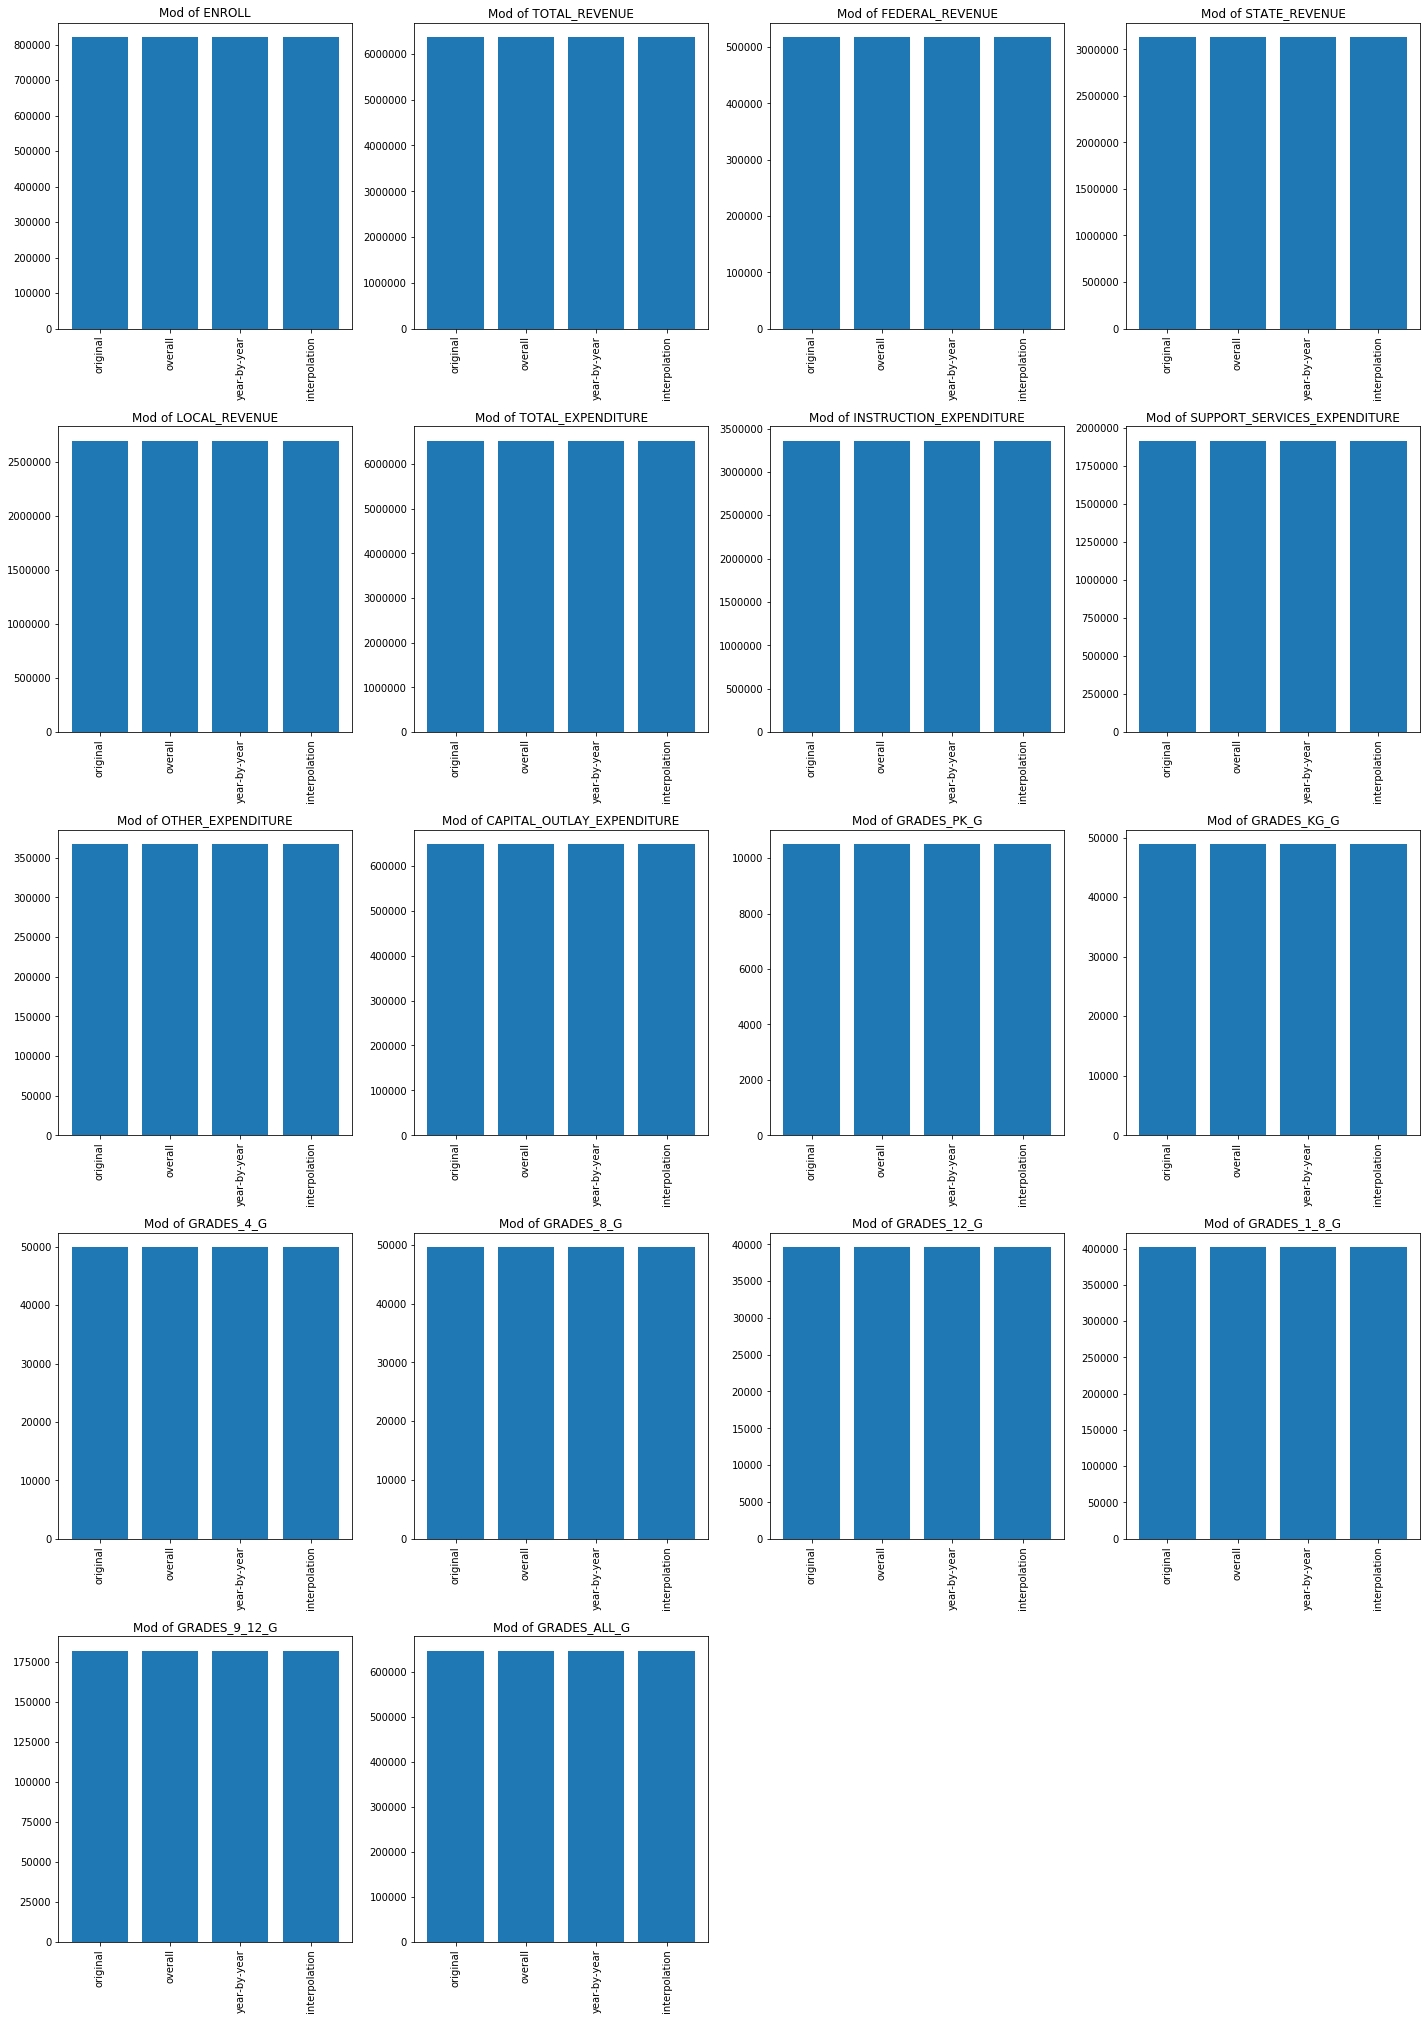

In [49]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,100))

for i, col in enumerate(fill_list):
    df = pd.concat([education_df[col], education_df_copy1[col],
                     education_df_copy2[col], education_df_copy3[col]], axis=1)
    
    plt.subplot(len(fill_list), 4, i+1)
    plt.bar(["original", "overall", "year-by-year", "interpolation"], df.median())
    plt.xticks(rotation='vertical')
    plt.title("Mod of {}".format(col))
    
plt.tight_layout()
plt.show()